In [1]:
import pandas as pd 
import numpy as np
import json

import scipy.stats as stats
from scipy.stats import kruskal, spearmanr, pearsonr, ttest_ind, shapiro, levene, mannwhitneyu, median_test

import seaborn as sns
import matplotlib.pyplot as plt 


import statsmodels.api as sm
import scikit_posthocs as sp


# PROJET 1

## (1) Informations sur les données (extrait du schéma Json)

 * URL : https://data.education.gouv.fr/explore/dataset/fr-en-college-effectifs-niveau-sexe-lv/

 * Ce jeu de données contient les effectifs des collèges par niveau, sexe, principales langues vivantes 1 et langues vivantes 2, observés au début du mois d’octobre de chaque année. 

 * Shape : 541 colonnes ; 32 982 enregistrements

 * Période : de la rentrée scolaire 2019 à la rentrée scolaire 2022 (Dernière observation le 01/10/2022.)

 * Les données comprennent les Établissements publics et privés sous contrat


In [2]:
# Lire le fichier JSON
with open('data_description.json', 'r') as file:
    schema = json.load(file)

# Initialiser des dictionnaires pour stocker les variables par type
variables_by_type = {
    "string": [],
    "integer": [],
    "float": [],
    "boolean": [],
    "array": [],
    "object": []
}

# Fonction récursive pour extraire les variables par type
def extract_variables(properties, prefix=""):
    for key, value in properties.items():
        var_type = value.get("type")
        if var_type:
            variables_by_type[var_type].append(prefix + key)
        # Vérifier les objets imbriqués
        if var_type == "object":
            extract_variables(value.get("properties", {}), prefix + key + ".")

# Extraire les propriétés du schéma JSON
fields_properties = schema["definitions"]["fr-en-college-effectifs-niveau-sexe-lv_records"]["properties"]["fields"]["properties"]
extract_variables(fields_properties)

# Afficher les variables par type
for var_type, variables in variables_by_type.items():
    if variables :
        print(f"Variables de type {var_type}:")
        for variable in variables:
            print(f" - {variable}")
        print()  

Variables de type string:
 - rentree_scolaire
 - region_academique
 - academie
 - departement
 - commune
 - numero_college
 - denomination_principale
 - patronyme
 - secteur
 - rep
 - rep_plus
 - code_postal

Variables de type integer:
 - nombre_eleves_total
 - nombre_eleves_total_hors_segpa_hors_ulis
 - nombre_eleves_segpa
 - nombre_eleves_ulis
 - 6eme_total
 - 6eme_hors_segpa_hors_ulis
 - 6eme_segpa
 - 6eme_ulis
 - 6eme_filles
 - 6emes_garcons
 - 6eme_lv1_allemand
 - 6eme_lv1_anglais
 - 6eme_lv1_espagnol
 - 6eme_lv1_autres
 - 6eme_lv2_allemand
 - 6eme_lv2_anglais
 - 6eme_lv2_espagnol
 - 6eme_lv2_italien
 - 6eme_lv2_autres
 - 5eme_total
 - 5eme_hors_segpa_hors_ulis
 - 5eme_segpa
 - 5eme_ulis
 - 5eme_filles
 - 5emes_garcons
 - 5eme_lv1_allemand
 - 5eme_lv1_anglais
 - 5eme_lv1_espagnol
 - 5eme_lv1_autres
 - 5eme_lv2_allemand
 - 5eme_lv2_anglais
 - 5eme_lv2_espagnol
 - 5eme_lv2_italien
 - 5eme_lv2_autres
 - 4eme_total
 - 4eme_hors_segpa_hors_ulis
 - 4eme_segpa
 - 4eme_ulis
 - 4eme_filles

 **Qualitatives** (permet d'apporter du contexte) :

   - Temporel : rentrée_scolaire
   - Organisationnel : academie, numero_college, secteur, rep, rep_plus  
   - Géographique : region_academique, departement, commune, code_postal 
   
   - Descriptif : denomination_principale, patronyme

 **Quantitatives** (permet d'apporter du poids) : 
 
   - Nombre d'éleves par catégorie : segpa, ulis, hors_segpa_hors_ulis et tous
   - 4 niveaux d'études : 6ème, 5ème, 4ème, 3ème
   - 15 catégories de quantification par niveau d'étude :
   
      * Nombre d'élève par niveau d'étude : total
      * Catégorie d'étude : hors_segpa_hors_ulis, segpa, ulis
      * Genres : filles, garcons
      * Langue vivante 1 : lv1_allemand, lv1_anglais, lv1_espagnol, lv1_autres, 
      * Langue vivante 2 : lv2_allemand, lv2_anglais, lv2_espagnol, lv2_italien, lv2_autres

### (1.1) DataFrame initial

In [3]:
initial_df = pd.read_csv('fr-en-college-effectifs-niveau-sexe-lv.csv', sep=';')
initial_df.head(5)

,Rentrée scolaire,Région,Académie,Département,Commune,Numéro du collège,Dénomination principale,Patronyme,Secteur,REP,...,3èmes LV1 allemand,3èmes LV1 anglais,3èmes LV1 espagnol,3èmes LV1 autres langues,3èmes LV2 allemand,3èmes LV2 anglais,3èmes LV2 espagnol,3èmes LV2 italien,3èmes LV2 autres langues,Code postal
0,2019,AUVERGNE-ET-RHONE-ALPES,LYON,RHONE,VILLEURBANNE,0691664J,COLLEGE,JEAN JAURES,PUBLIC,1,...,0,175,0,0,26,0,131,14,0,69100.0
1,2019,AUVERGNE-ET-RHONE-ALPES,LYON,RHONE,VILLEURBANNE,0692390Y,ETAB.REGIONAL ENSEIGNT ADAPTE,CITE SCOLAIRE RENE PELLET,PUBLIC,0,...,0,15,0,0,0,0,15,0,0,69602.0
2,2019,AUVERGNE-ET-RHONE-ALPES,LYON,RHONE,VILLEURBANNE,0693093M,COLLEGE,DU TONKIN,PUBLIC,0,...,0,124,0,0,35,0,89,0,0,69616.0
3,2019,AUVERGNE-ET-RHONE-ALPES,LYON,RHONE,VILLEURBANNE,0694296V,COLLEGE,SIMONE LAGRANGE,PUBLIC,0,...,0,89,0,0,12,0,73,0,4,69100.0
4,2019,AUVERGNE-ET-RHONE-ALPES,LYON,RHONE,VILLIE-MORGON,0690117C,COLLEGE,JEAN CLAUDE RUET,PUBLIC,0,...,0,101,0,0,2,0,72,27,0,69910.0


In [4]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32982 entries, 0 to 32981
Data columns (total 76 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Rentrée scolaire                            32982 non-null  int64  
 1   Région                                      32982 non-null  object 
 2   Académie                                    32982 non-null  object 
 3   Département                                 32982 non-null  object 
 4   Commune                                     32982 non-null  object 
 5   Numéro du collège                           32982 non-null  object 
 6   Dénomination principale                     32982 non-null  object 
 7   Patronyme                                   32927 non-null  object 
 8   Secteur                                     32982 non-null  object 
 9   REP                                         32982 non-null  int64  
 10  REP +     

### (1.2) Nombre de collèges concernés par l'étude

In [5]:
num_unique_colleges = initial_df['Numéro du collège'].nunique()
print(f"Les données concernent un total de {num_unique_colleges} collèges.")


Les données concernent un total de 8337 collèges.


### (1.3) Calcul du taux de décrochage

In [6]:

df = initial_df[['Numéro du collège', "Nombre d'élèves total", 
                 'Région', 'Secteur',
                 '6èmes garçons', '6èmes filles',
                 '5èmes garçons', '5èmes filles',
                 '4èmes garçons', '4èmes filles',
                 '3èmes garçons', '3èmes filles',
                ]].copy() 

#Filles

df['delta_6_5_F'] = df['5èmes filles'] - df['6èmes filles']
df['taux_6_5_F'] = df['delta_6_5_F'] / df['6èmes filles']

df['delta_5_4_F'] = df['4èmes filles'] - df['5èmes filles']
df['taux_5_4_F'] = df['delta_5_4_F'] / df['5èmes filles']

df['delta_4_3_F'] = df['3èmes filles'] - df['4èmes filles']
df['taux_4_3_F'] = df['delta_4_3_F'] / df['4èmes filles']

df['DELTA_F'] = df['delta_6_5_F'] + df['delta_5_4_F'] + df['delta_4_3_F']
df['nb_F'] = (df['6èmes filles'] + df['5èmes filles'] + df['4èmes filles'] + df['3èmes filles'])

df['TAUX_F'] = df['DELTA_F'] / (df['nb_F'])
df['TAUX_F'] = df['TAUX_F'].fillna(0)

#---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- #Symétrie

#Garçons

df['delta_6_5_G'] = df['5èmes garçons'] - df['6èmes garçons']
df['taux_6_5_G'] = df['delta_6_5_G'] / df['6èmes garçons']

df['delta_5_4_G'] = df['4èmes garçons'] - df['5èmes garçons']
df['taux_5_4_G'] = df['delta_5_4_G'] / df['5èmes garçons']

df['delta_4_3_G'] = df['3èmes garçons'] - df['4èmes garçons']
df['taux_4_3_G'] = df['delta_4_3_G'] / df['4èmes garçons']

df['DELTA_G'] = df['delta_6_5_G'] + df['delta_5_4_G'] + df['delta_4_3_G']
df['nb_G'] = (df['6èmes garçons'] + df['5èmes garçons'] + df['4èmes garçons'] + df['3èmes garçons'])

df['TAUX_G'] = df['DELTA_G'] / df['nb_G']
df['TAUX_G'] = df['TAUX_G'].fillna(0)



df['TAUX'] = (df['DELTA_F'] + df['DELTA_G']) / ((df['nb_F']) + (df['nb_G']))

df.head()

,Numéro du collège,Nombre d'élèves total,Région,Secteur,6èmes garçons,6èmes filles,5èmes garçons,5èmes filles,4èmes garçons,4èmes filles,...,delta_6_5_G,taux_6_5_G,delta_5_4_G,taux_5_4_G,delta_4_3_G,taux_4_3_G,DELTA_G,nb_G,TAUX_G,TAUX
0,0691664J,779,AUVERGNE-ET-RHONE-ALPES,PUBLIC,98,110,98,95,95,95,...,0,0.000000,-3,-0.030612,-7,-0.073684,-10,379,-0.026385,-0.025674
1,0692390Y,59,AUVERGNE-ET-RHONE-ALPES,PUBLIC,10,5,9,4,12,4,...,-1,-0.100000,3,0.333333,-5,-0.416667,-3,38,-0.078947,0.000000
2,0693093M,450,AUVERGNE-ET-RHONE-ALPES,PUBLIC,51,42,48,58,59,68,...,-3,-0.058824,11,0.229167,6,0.101695,14,223,0.062780,0.068889
3,0694296V,398,AUVERGNE-ET-RHONE-ALPES,PUBLIC,61,63,44,49,58,34,...,-17,-0.278689,14,0.318182,-10,-0.172414,-13,211,-0.061611,-0.087940
4,0690117C,432,AUVERGNE-ET-RHONE-ALPES,PUBLIC,56,59,46,60,58,52,...,-10,-0.178571,12,0.260870,-26,-0.448276,-24,192,-0.125000,-0.032407


### (1.4) Vérification de la distribution

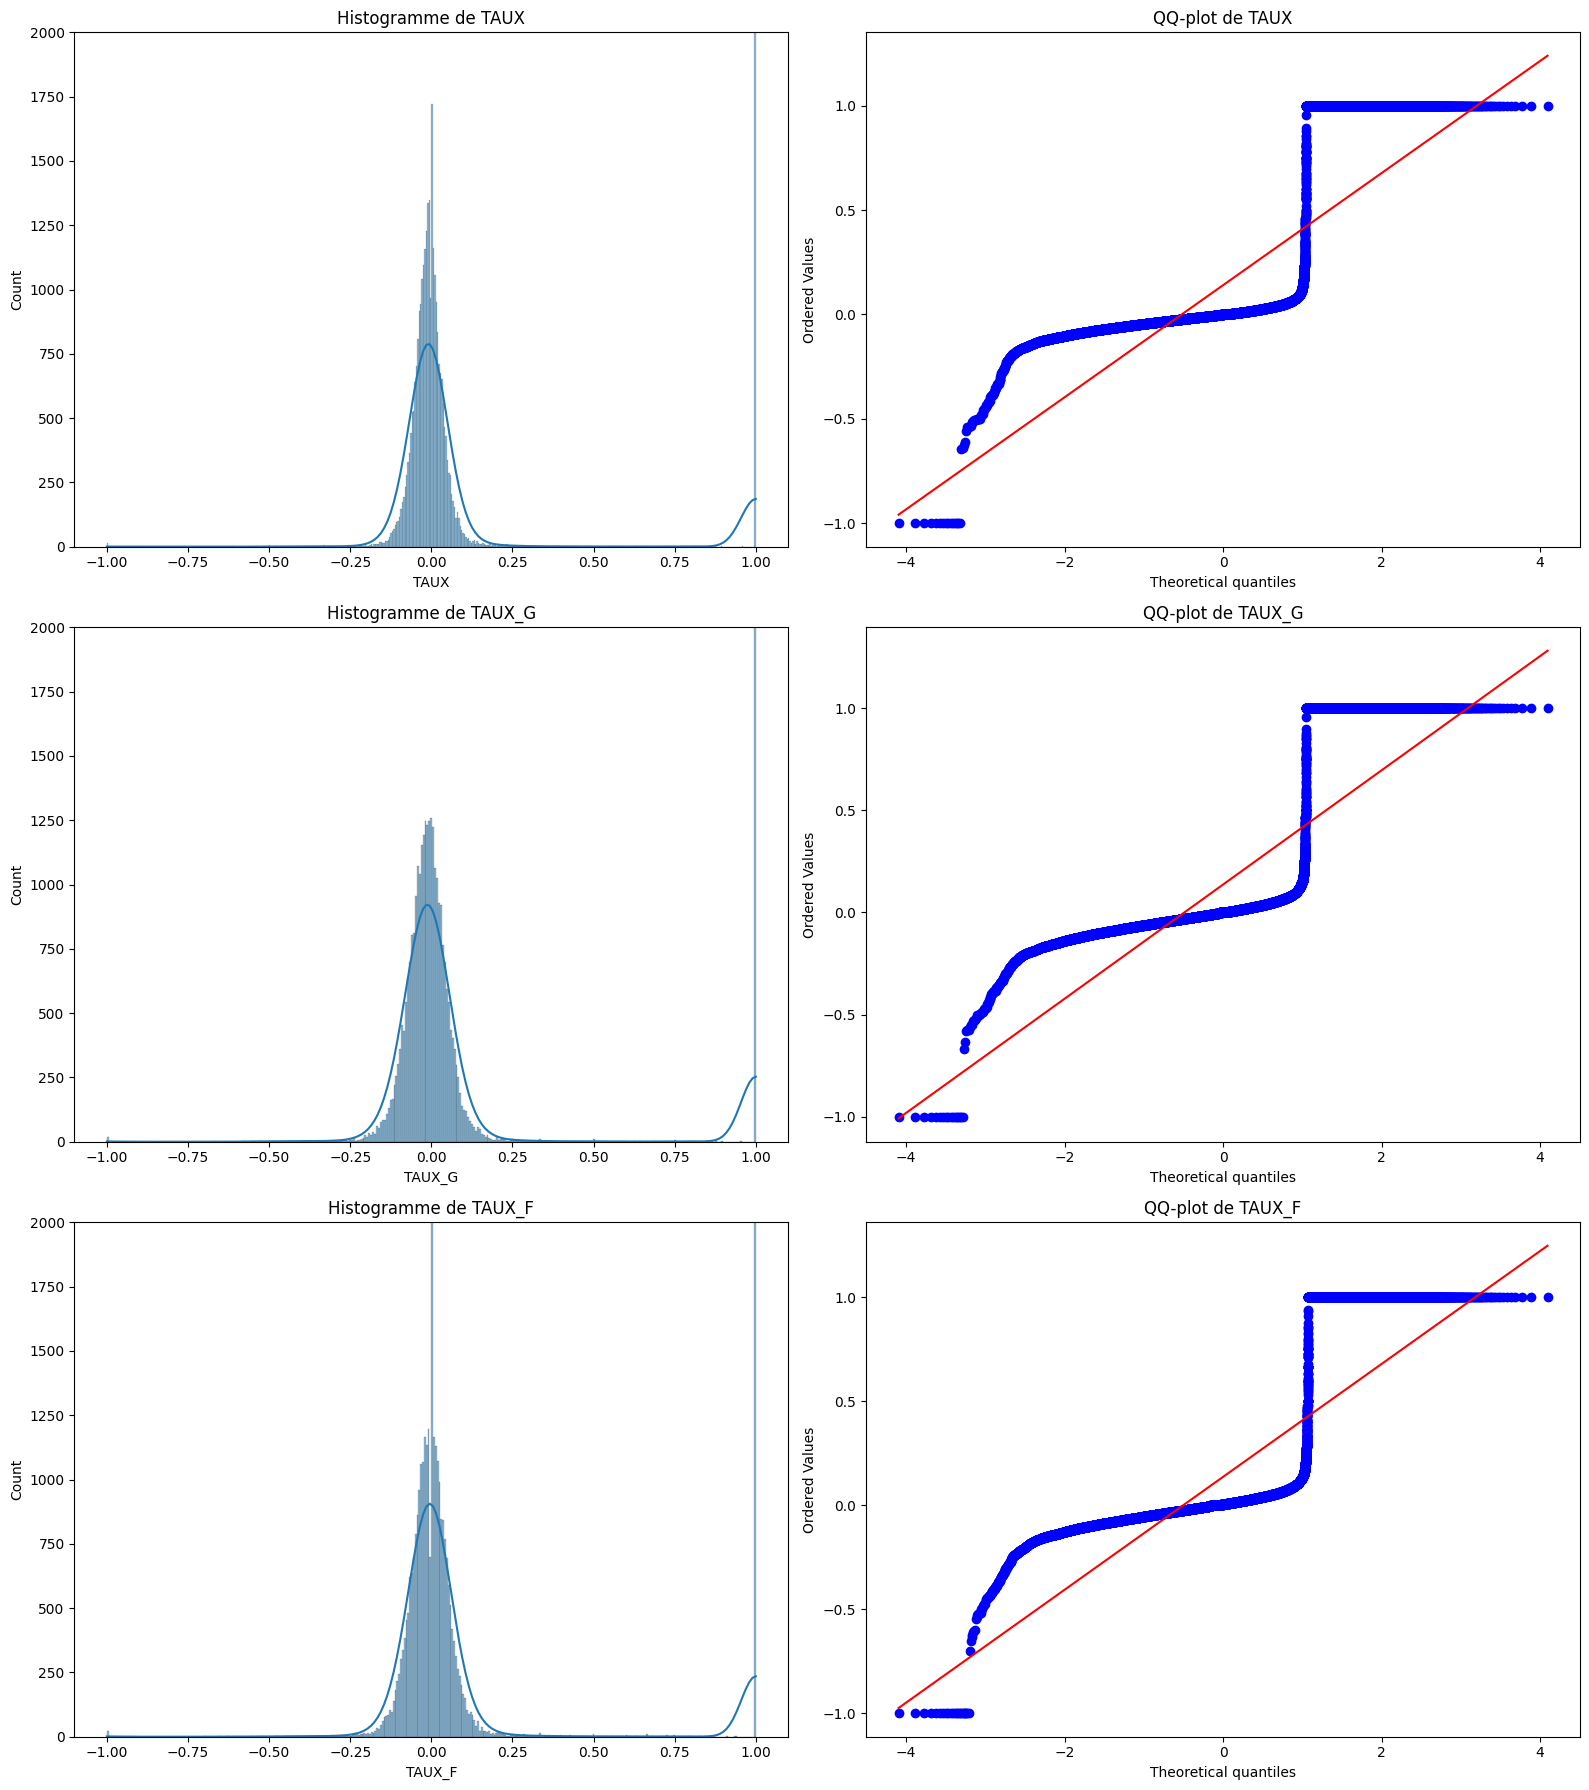

Résultats des tests de normalité pour TAUX :
---------------------------------------------------------------------
Test de Shapiro-Wilk:  Statistique: 0.5411  p-value: 0.0000

Test de Kolmogorov-Smirnov:  Statistique: 0.4390  p-value: 0.0000

Test d'Anderson-Darling:  Statistique: 7161.5146  Seuils: [0.576 0.656 0.787 0.918 1.092]  Significativité: [15.  10.   5.   2.5  1. ]

Test de Jarque-Bera:  Statistique: 23575.7370  p-value: 0.0000

Statistiques descriptives pour TAUX :
Skewness: 1.8721
Kurtosis: 1.7708

Résultats des tests de normalité pour TAUX_G :
---------------------------------------------------------------------
Test de Shapiro-Wilk:  Statistique: 0.5770  p-value: 0.0000

Test de Kolmogorov-Smirnov:  Statistique: 0.4227  p-value: 0.0000

Test d'Anderson-Darling:  Statistique: 6436.0972  Seuils: [0.576 0.656 0.787 0.918 1.092]  Significativité: [15.  10.   5.   2.5  1. ]

Test de Jarque-Bera:  Statistique: 22335.1778  p-value: 0.0000

Statistiques descriptives pour TAUX_G :

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Définition de la figure avec trois sous-graphiques côte à côte
fig, ax = plt.subplots(3, 2, figsize=(16, 18))

# Histogrammes des données 'TAUX', 'TAUX_G' et 'TAUX_F'
sns.histplot(df['TAUX'], kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Histogramme de TAUX')
ax[0, 0].set_ylim(top=2000)

sns.histplot(df['TAUX_G'], kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Histogramme de TAUX_G')
ax[1, 0].set_ylim(top=2000)

sns.histplot(df['TAUX_F'], kde=True, ax=ax[2, 0])
ax[2, 0].set_title('Histogramme de TAUX_F')
ax[2, 0].set_ylim(top=2000)

# QQ-plots pour vérifier la normalité de 'TAUX', 'TAUX_G' et 'TAUX_F'
stats.probplot(df['TAUX'], dist="norm", plot=ax[0, 1])
ax[0, 1].set_title('QQ-plot de TAUX')

stats.probplot(df['TAUX_G'], dist="norm", plot=ax[1, 1])
ax[1, 1].set_title('QQ-plot de TAUX_G')

stats.probplot(df['TAUX_F'], dist="norm", plot=ax[2, 1])
ax[2, 1].set_title('QQ-plot de TAUX_F')

plt.tight_layout()
plt.show()

# Tests de normalité et statistiques descriptives pour 'TAUX', 'TAUX_G' et 'TAUX_F'
for name, data in zip(['TAUX', 'TAUX_G', 'TAUX_F'], [df['TAUX'], df['TAUX_G'], df['TAUX_F']]):
    shapiro_test = stats.shapiro(data[:5000])  # Test de Shapiro-Wilk avec sous-échantillon
    ks_test = stats.kstest(data, 'norm')
    anderson_test = stats.anderson(data, dist='norm')
    jarque_bera_test = stats.jarque_bera(data)
    
    print(f"Résultats des tests de normalité pour {name} :\n---------------------------------------------------------------------")
    print(f"Test de Shapiro-Wilk:"
          f"  Statistique: {shapiro_test.statistic:.4f}"
          f"  p-value: {shapiro_test.pvalue:.4f}\n")
    
    print(f"Test de Kolmogorov-Smirnov:"
          f"  Statistique: {ks_test.statistic:.4f}"
          f"  p-value: {ks_test.pvalue:.4f}\n")
    
    print(f"Test d'Anderson-Darling:"
          f"  Statistique: {anderson_test.statistic:.4f}"
          f"  Seuils: {anderson_test.critical_values}"
          f"  Significativité: {anderson_test.significance_level}\n")
    
    print(f"Test de Jarque-Bera:"
          f"  Statistique: {jarque_bera_test.statistic:.4f}"
          f"  p-value: {jarque_bera_test.pvalue:.4f}\n")
    
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    
    print(f"Statistiques descriptives pour {name} :")
    print(f"Skewness: {skewness:.4f}")
    print(f"Kurtosis: {kurtosis:.4f}\n")


--> D'après le QQ-Plot et les différents test de normalité, on observe que la distribution du taux de décrochage ne suit pas une distribution normale.   

Cela peux être expliqué par le fait que certains collèges répondent à des besoins différents (formation générale Vs formation professionnelle)  

Dans le cadre de cette étude, nous nous intérressons à l'ensemble des collèges de France, ce qui explique que nos données ne sont pas distribuées de façon normale. 


## (2) Questions
### (2.1) Question 1 : *Certains collèges ont t'ils davantage de décrochages scolaire que d'autres ? (réduction du nombre d'élèves entre la 6e et la 3e)*

#### (2.1.1) Test de Kruskal-Wallis (différence entre plusieurs groupes - non-paramétrique)
##### (a) Conditions d'application

* Indépendance des observations : (OK)

    Les échantillons doivent être indépendants les uns des autres. Cela signifie que le taux de décrochage dans un groupe ne doit pas influencer le taux de décrochage dans un autre groupe.

* Variable de réponse ordinale ou continue : (OK)

    La variable de réponse, ici le taux de décrochage, doit être mesurée sur une échelle au moins ordinale. Cependant, le test de Kruskal-Wallis est généralement utilisé avec des données continues.

* Distribution similaire : (OK)

    Bien que les distributions ne doivent pas nécessairement être normales, elles doivent avoir des formes similaires pour que les comparaisons soient valides.

##### (b) Résultats

In [8]:
data = [df[df["Numéro du collège"] == college]['TAUX'] for college in df["Numéro du collège"].unique()]     # Préparation des données
h_statistic, p_value = kruskal(*data)                                                                       # Test de Kruskal-Wallis

print(f"Test de Kruskal-Wallis : H = {h_statistic}, p-value = {p_value}")

if p_value < 0.05:
    print("Il y a des preuves suffisantes pour conclure que certains collèges ont davantage de décrochages scolaires que d'autres")
else:
    print("Il n'y a pas de preuves suffisantes pour conclure que certains collèges ont davantage de décrochages scolaires que d'autres")

Test de Kruskal-Wallis : H = 21288.252250142534, p-value = 0.0
Il y a des preuves suffisantes pour conclure que certains collèges ont davantage de décrochages scolaires que d'autres


### (2.2) Question 2 : *Cette tendance a-t'elle un lien avec la taille du collège ? (volume d'étudiants)*
#### (2.2.1) Analyse de la corrélation

Corrélation de Pearson: -0.6129632557707855, p-value: 0.0
Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire (Pearson).

Corrélation de Spearman: -0.34950303939733135, p-value: 0.0
Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire (Spearman).



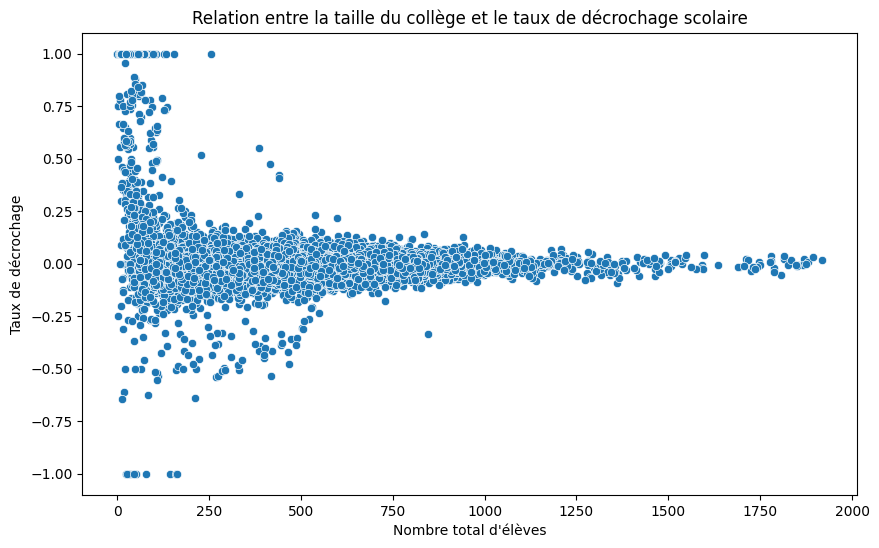

In [9]:
# Corrélation de Pearson
pearson_corr, pearson_p_value = pearsonr(df["Nombre d'élèves total"], df['TAUX'])
print(f"Corrélation de Pearson: {pearson_corr}, p-value: {pearson_p_value}")

if pearson_p_value < 0.05:
    if pearson_corr > 0:
        print("Il existe une corrélation positive significative entre la taille du collège et le taux de décrochage scolaire (Pearson).\n")
    else:
        print("Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire (Pearson).\n")
else:
    print("Aucune corrélation significative n'a été trouvée entre la taille du collège et le taux de décrochage scolaire (Pearson).\n")

# Corrélation de Spearman
spearman_corr, spearman_p_value = spearmanr(df["Nombre d'élèves total"], df['TAUX'])
print(f"Corrélation de Spearman: {spearman_corr}, p-value: {spearman_p_value}")     # Corrélation de Spearman

if spearman_p_value < 0.05:
    if spearman_corr > 0:
        print("Il existe une corrélation positive significative entre la taille du collège et le taux de décrochage scolaire (Spearman).\n")
    else:
        print("Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire (Spearman).\n")
else:
    print("Aucune corrélation significative n'a été trouvée entre la taille du collège et le taux de décrochage scolaire (Spearman).\n")

# Visualisation de la relation
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Nombre d'élèves total", y='TAUX', data=df)
plt.title('Relation entre la taille du collège et le taux de décrochage scolaire')
plt.xlabel('Nombre total d\'élèves')
plt.ylabel('Taux de décrochage')
plt.show()


Il y a une relation statistiquement significative qui indique que, en moyenne, les collèges plus grands ont tendance à avoir un taux de décrochage scolaire plus faible.   
Autrement dit, à mesure que la taille du collège augmente, le taux de décrochage scolaire tend à diminuer de manière significative.

### (2.3) Question 3 : *Est-ce la même conclusion pour les garçons que pour les filles ?*
#### (2.3.2) Vérification de la normalité (Shapiro) et de l'homoscédasticité (Test de Levene)

In [10]:
# Vérification de la normalité des distributions
stat_g, p_g = shapiro(df['TAUX_G'][:5000])
stat_f, p_f = shapiro(df['TAUX_F'][:5000])

print(f"Test de Shapiro-Wilk pour les garçons - Statistique : {stat_g}, p-value : {p_g}")
print(f"Test de Shapiro-Wilk pour les filles - Statistique : {stat_f}, p-value : {p_f}")

if p_g > 0.05 and p_f > 0.05:
    print("Les taux de décrochage pour les garçons et les filles suivent une distribution normale.\n")
else:
    print("Les taux de décrochage pour les garçons et/ou les filles ne suivent pas une distribution normale.\n")

# Vérification de l'homoscédasticité
stat_levene, p_levene = levene(df['TAUX_G'], df['TAUX_F'])

print(f"Test de Levene pour l'homoscédasticité - Statistique : {stat_levene}, p-value : {p_levene}")

if p_levene > 0.05:
    print("Les variances des taux de décrochage pour les garçons et les filles sont égales.\n")
else:
    print("Les variances des taux de décrochage pour les garçons et/ou les filles ne sont pas égales.\n")


Test de Shapiro-Wilk pour les garçons - Statistique : 0.5770321058417683, p-value : 1.4229564194133173e-76
Test de Shapiro-Wilk pour les filles - Statistique : 0.5689628995828706, p-value : 5.668667711697843e-77
Les taux de décrochage pour les garçons et/ou les filles ne suivent pas une distribution normale.

Test de Levene pour l'homoscédasticité - Statistique : 8.071235014617077, p-value : 0.0044987229252916715
Les variances des taux de décrochage pour les garçons et/ou les filles ne sont pas égales.



#### (2.3.2) Test de Mann-Whitney U (différence de distribution entre deux échantillons - non paramétrique)

In [11]:
# Test de Mann-Whitney U
statistic, p_value = mannwhitneyu(df['TAUX_G'], df['TAUX_F'])

print(f"Test de Mann-Whitney U - Statistique : {statistic}, p-value : {p_value}")

# Interprétation des résultats
if p_value < 0.05:
    print("Conclusion : Il y a une différence significative entre les distributions des taux de décrochage des garçons et des filles.")
else:
    print("Conclusion : Aucune différence significative n'a été trouvée entre les distributions des taux de décrochage des garçons et des filles.")

Test de Mann-Whitney U - Statistique : 517670892.5, p-value : 6.2684978501196734e-27
Conclusion : Il y a une différence significative entre les distributions des taux de décrochage des garçons et des filles.


#### (2.3.3) Test de médiane

In [12]:
# Calcul des médianes et test de médiane
median_g = df['TAUX_G'].median()
median_f = df['TAUX_F'].median()

print(f"Médiane des taux de décrochage pour les garçons : {median_g}")
print(f"Médiane des taux de décrochage pour les filles : {median_f}")

# Test de médiane pour vérifier si les médianes sont significativement différentes
statistic, p_value, _, _ = median_test(df['TAUX_G'], df['TAUX_F'])

print(f"Test de médiane - Statistique : {statistic}, p-value : {p_value}")

if p_value < 0.05:
    print("Conclusion : Les médianes des taux de décrochage sont significativement différentes entre les garçons et les filles.")
else:
    print("Conclusion : Aucune différence significative n'a été trouvée entre les médianes des taux de décrochage des garçons et des filles.")

Médiane des taux de décrochage pour les garçons : 0.0
Médiane des taux de décrochage pour les filles : 0.005263157894736842
Test de médiane - Statistique : 86.59420289855072, p-value : 1.3323713561496906e-20
Conclusion : Les médianes des taux de décrochage sont significativement différentes entre les garçons et les filles.


#### (2.3.4) Analyse de corrélation

Corrélation de Pearson: -0.6067231802297698, p-value: 0.0
Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire chez les garçons(Pearson).

Corrélation de Pearson: -0.5946664095737048, p-value: 0.0
Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire chez les filles (Pearson).

Corrélation de Spearman: -0.3508985226894085, p-value: 0.0
Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire chez les garçons (Spearman).

Corrélation de Spearman: -0.3530304139574889, p-value: 0.0
Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire chez les filles (Spearman).



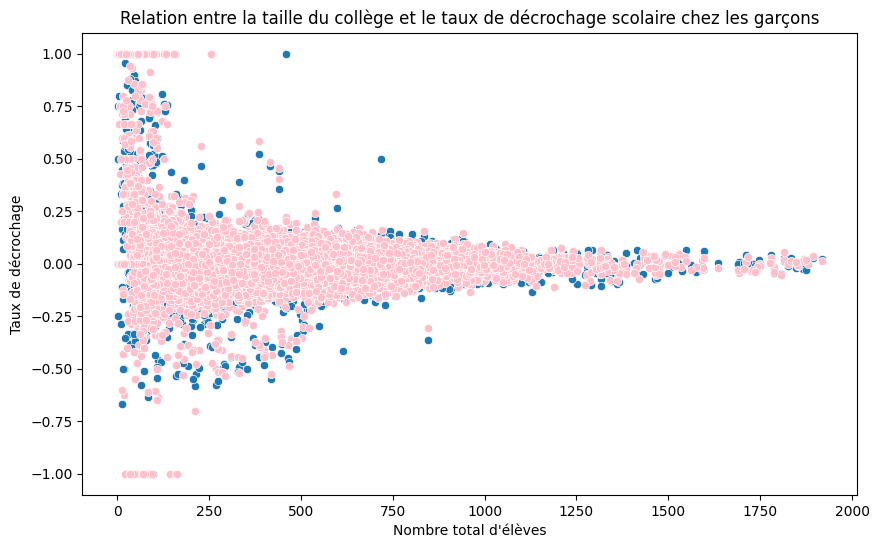

In [13]:
# Corrélation de Pearson
pearson_corr, pearson_p_value = pearsonr(df["Nombre d'élèves total"], df['TAUX_G'])
print(f"Corrélation de Pearson: {pearson_corr}, p-value: {pearson_p_value}")

if pearson_p_value < 0.05:
    if pearson_corr > 0:
        print("Il existe une corrélation positive significative entre la taille du collège et le taux de décrochage scolaire chez les garçons (Pearson).\n")
    else:
        print("Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire chez les garçons(Pearson).\n")
else:
    print("Aucune corrélation significative n'a été trouvée entre la taille du collège et le taux de décrochage scolaire chez les garçons (Pearson).\n")

#---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- --

pearson_corr, pearson_p_value = pearsonr(df["Nombre d'élèves total"], df['TAUX_F'])
print(f"Corrélation de Pearson: {pearson_corr}, p-value: {pearson_p_value}")

if pearson_p_value < 0.05:
    if pearson_corr > 0:
        print("Il existe une corrélation positive significative entre la taille du collège et le taux de décrochage scolaire chez les filles (Pearson).\n")
    else:
        print("Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire chez les filles (Pearson).\n")
else:
    print("Aucune corrélation significative n'a été trouvée entre la taille du collège et le taux de décrochage scolaire chez les filles (Pearson).\n")


# Corrélation de Spearman
spearman_corr, spearman_p_value = spearmanr(df["Nombre d'élèves total"], df['TAUX_G'])
print(f"Corrélation de Spearman: {spearman_corr}, p-value: {spearman_p_value}")     # Corrélation de Spearman

if spearman_p_value < 0.05:
    if spearman_corr > 0:
        print("Il existe une corrélation positive significative entre la taille du collège et le taux de décrochage scolaire chez les garçons(Spearman).\n")
    else:
        print("Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire chez les garçons (Spearman).\n")
else:
    print("Aucune corrélation significative n'a été trouvée entre la taille du collège et le taux de décrochage scolaire chez les garçons (Spearman).\n")

#---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- -- ---- --

spearman_corr, spearman_p_value = spearmanr(df["Nombre d'élèves total"], df['TAUX_F'])
print(f"Corrélation de Spearman: {spearman_corr}, p-value: {spearman_p_value}")     # Corrélation de Spearman

if spearman_p_value < 0.05:
    if spearman_corr > 0:
        print("Il existe une corrélation positive significative entre la taille du collège et le taux de décrochage scolaire chez les filles (Spearman).\n")
    else:
        print("Il existe une corrélation négative significative entre la taille du collège et le taux de décrochage scolaire chez les filles (Spearman).\n")
else:
    print("Aucune corrélation significative n'a été trouvée entre la taille du collège et le taux de décrochage scolaire chez les filles (Spearman).\n")

# Visualisation de la relation
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Nombre d'élèves total", y='TAUX_G', data=df, color='#1f77b4')
sns.scatterplot(x="Nombre d'élèves total", y='TAUX_F', data=df, color='pink')
plt.title('Relation entre la taille du collège et le taux de décrochage scolaire chez les garçons')
plt.xlabel('Nombre total d\'élèves')
plt.ylabel('Taux de décrochage')
plt.show()



**Conclusion :** La variance du taux de décrochage chez les garçons et chez les filles est différente.   
En revanche, les taux de décrochages chez les garçons et chez les filles fluctuent de la même façon en fonction de la taille du collège. 

### (2.4) Question 4 : *Est-ce que le constat change en fonction de la région ?*
#### (2.4.1) Statistiques descriptives

1. Description des données par région
Statistiques descriptives : Commencez par examiner les statistiques descriptives (moyenne, médiane, écart-type, etc.) des variables d'intérêt pour chaque région.  
Visualisation : Utilisez des graphiques comme des boxplots ou des diagrammes en barres pour visualiser les différences entre les régions.  

2. Tests de normalité
Vérifiez si les données sont normalement distribuées dans chaque région (tests de Shapiro-Wilk, Kolmogorov-Smirnov, etc.).  

3. Comparaison entre les régions
ANOVA ou Kruskal-Wallis : Si vous avez plus de deux régions à comparer, utilisez l'ANOVA (si les données sont normales et les variances homogènes) ou le test de Kruskal-Wallis (si les données ne sont pas normales).  
Post hoc tests : Si le test ANOVA ou Kruskal-Wallis montre des différences significatives, effectuez des tests post hoc (comme Tukey pour ANOVA ou Dunn pour Kruskal-Wallis) pour identifier quelles régions diffèrent spécifiquement les unes des autres.  
Mann-Whitney U test : Si vous comparez seulement deux régions à la fois et que les données ne sont pas normalement distribuées, utilisez le test de Mann-Whitney U.  

4. Modèles statistiques
Analyse de variance à deux facteurs (ANOVA à deux facteurs) : Si vous souhaitez analyser l'effet de deux facteurs (par exemple, traitement et région) simultanément, vous pouvez utiliser une ANOVA à deux facteurs.  
Modèles mixtes : Pour tenir compte de la variabilité intra-régionale et inter-régionale, envisagez des modèles à effets mixtes.  

5. Interactions
Interactions dans les modèles : Lors de la construction de modèles, incluez des termes d'interaction entre les facteurs (par exemple, traitement*region) pour voir si l'effet du traitement varie selon la région.  

In [14]:
descriptive_stats = df.groupby('Région').agg({
    'TAUX': ['mean', 'median', 'std'],
    'TAUX_G': ['mean', 'median', 'std'],
    'TAUX_F': ['mean', 'median', 'std']
}).reset_index()

descriptive_stats.columns = ['_'.join(col).strip() for col in descriptive_stats.columns.values]

descriptive_stats.head()

,Région_,TAUX_mean,TAUX_median,TAUX_std,TAUX_G_mean,TAUX_G_median,TAUX_G_std,TAUX_F_mean,TAUX_F_median,TAUX_F_std
0,AUVERGNE-ET-RHONE-ALPES,0.165979,-0.001838,0.388773,0.162226,0.000000,0.391848,0.161227,0.005435,0.382438
1,BOURGOGNE-ET-FRANCHE-COMTE,0.149242,0.000000,0.371808,0.144066,0.000000,0.376545,0.147456,0.008982,0.364922
2,BRETAGNE,0.107379,-0.005747,0.333314,0.102040,-0.007519,0.337057,0.107015,0.004149,0.328352
3,CENTRE-VAL-DE-LOIRE,0.138674,0.000000,0.356420,0.135435,0.000000,0.359735,0.140810,0.005222,0.356339
4,CORSE,0.027125,-0.002340,0.182141,0.028741,0.006564,0.189458,0.024207,-0.003619,0.186116


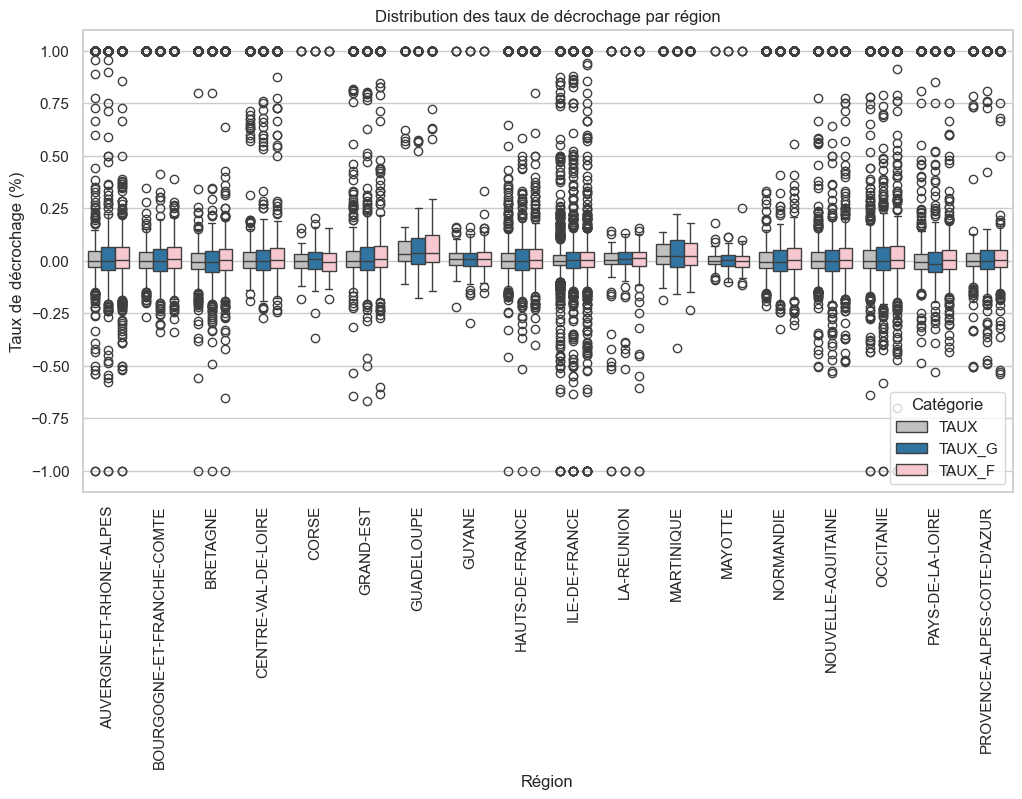

In [15]:
# Transformation du DataFrame "long" pour visualiser les taux de décrochage par genre et par région
df_long = pd.melt(df, id_vars=['Région'], value_vars=['TAUX', 'TAUX_G', 'TAUX_F'], 
                  var_name='Catégorie', value_name='Taux de décrochage')

# Configuration des graphiques avec seaborn
sns.set(style="whitegrid")

# Boxplot avec superposition des catégories
plt.figure(figsize=(12, 6))
sns.boxplot(x='Région', y='Taux de décrochage', hue='Catégorie', data=df_long,
            palette=sns.color_palette(['silver', '#1f77b4', 'pink']))  # Choix de couleurs
plt.title('Distribution des taux de décrochage par région')
plt.xlabel('Région')
plt.ylabel('Taux de décrochage (%)')

# Rotation des étiquettes à 90 degrés
plt.xticks(rotation=90)

plt.legend(title='Catégorie')
plt.show()

#### (2.4.2) Test de Kruskal-Wallis

In [16]:
# Test de Kruskal-Wallis pour chaque catégorie de taux de décrochage
regions = df['Région'].unique()
taux_by_region = [df[df['Région'] == region]['TAUX'] for region in regions]
taux_g_by_region = [df[df['Région'] == region]['TAUX_G'] for region in regions]
taux_f_by_region = [df[df['Région'] == region]['TAUX_F'] for region in regions]

statistic_taux, p_value_taux = kruskal(*taux_by_region)
statistic_taux_g, p_value_taux_g = kruskal(*taux_g_by_region)
statistic_taux_f, p_value_taux_f = kruskal(*taux_f_by_region)

# Affichage des résultats
print(f'Test de Kruskal-Wallis pour les taux de décrochage total :')
print(f'Statistique de test : {statistic_taux}')
print(f'Valeur de p : {p_value_taux}')
if p_value_taux < 0.05:
    print('Il y a des preuves statistiquement significatives que les distributions des taux de décrochage total sont différentes entre les régions.')
else:
    print('Il n\'y a pas suffisamment de preuves pour conclure que les distributions des taux de décrochage total sont différentes entre les régions.')

print('\nTest de Kruskal-Wallis pour les taux de décrochage des garçons :')
print(f'Statistique de test : {statistic_taux_g}')
print(f'Valeur de p : {p_value_taux_g}')
if p_value_taux_g < 0.05:
    print('Il y a des preuves statistiquement significatives que les distributions des taux de décrochage des garçons sont différentes entre les régions.')
else:
    print('Il n\'y a pas suffisamment de preuves pour conclure que les distributions des taux de décrochage des garçons sont différentes entre les régions.')

print('\nTest de Kruskal-Wallis pour les taux de décrochage des filles :')
print(f'Statistique de test : {statistic_taux_f}')
print(f'Valeur de p : {p_value_taux_f}')
if p_value_taux_f < 0.05:
    print('Il y a des preuves statistiquement significatives que les distributions des taux de décrochage des filles sont différentes entre les régions.')
else:
    print('Il n\'y a pas suffisamment de preuves pour conclure que les distributions des taux de décrochage des filles sont différentes entre les régions.')

Test de Kruskal-Wallis pour les taux de décrochage total :
Statistique de test : 187.10778702678047
Valeur de p : 1.1007599165308301e-30
Il y a des preuves statistiquement significatives que les distributions des taux de décrochage total sont différentes entre les régions.

Test de Kruskal-Wallis pour les taux de décrochage des garçons :
Statistique de test : 158.06019273312148
Valeur de p : 6.406211902654458e-25
Il y a des preuves statistiquement significatives que les distributions des taux de décrochage des garçons sont différentes entre les régions.

Test de Kruskal-Wallis pour les taux de décrochage des filles :
Statistique de test : 111.54110766020254
Valeur de p : 6.185692376844099e-16
Il y a des preuves statistiquement significatives que les distributions des taux de décrochage des filles sont différentes entre les régions.


#### (2.4.3) Test de Dunn

In [17]:
# Si le test de Kruskal-Wallis montre des différences significatives, réaliser le test de Dunn
if p_value_taux < 0.05:
    print('\nTest de Dunn pour les taux de décrochage total :')
    dunn_taux = sp.posthoc_dunn(df, val_col='TAUX', group_col='Région', p_adjust='bonferroni')
    print(dunn_taux)

if p_value_taux_g < 0.05:
    print('\nTest de Dunn pour les taux de décrochage des garçons :')
    dunn_taux_g = sp.posthoc_dunn(df, val_col='TAUX_G', group_col='Région', p_adjust='bonferroni')
    print(dunn_taux_g)

if p_value_taux_f < 0.05:
    print('\nTest de Dunn pour les taux de décrochage des filles :')
    dunn_taux_f = sp.posthoc_dunn(df, val_col='TAUX_F', group_col='Région', p_adjust='bonferroni')
    print(dunn_taux_f)


Test de Dunn pour les taux de décrochage total :
                            AUVERGNE-ET-RHONE-ALPES  \
AUVERGNE-ET-RHONE-ALPES                1.000000e+00   
BOURGOGNE-ET-FRANCHE-COMTE             1.000000e+00   
BRETAGNE                               5.822098e-02   
CENTRE-VAL-DE-LOIRE                    1.000000e+00   
CORSE                                  1.000000e+00   
GRAND-EST                              1.000000e+00   
GUADELOUPE                             3.851573e-13   
GUYANE                                 1.000000e+00   
HAUTS-DE-FRANCE                        1.000000e+00   
ILE-DE-FRANCE                          1.000000e+00   
LA-REUNION                             1.000000e+00   
MARTINIQUE                             1.803516e-05   
MAYOTTE                                1.000000e+00   
NORMANDIE                              1.000000e+00   
NOUVELLE-AQUITAINE                     1.000000e+00   
OCCITANIE                              1.000000e+00   
PAYS-DE-LA-LOIR

##### Synthèse : (Faire une Heatmap pour les régions)
* Taux de décrochage total :

    - "AUVERGNE-ET-RHONE-ALPES" vs "GUADELOUPE" : p-value = 3.851573e-13 (différence significative)
    - "AUVERGNE-ET-RHONE-ALPES" vs "MARTINIQUE" : p-value = 1.803516e-05 (différence significative)
    - "PAYS-DE-LA-LOIRE" vs "GUADELOUPE" : p-value = 1.276368e-19 (différence significative)

* Taux de décrochage des garçons :

    - "AUVERGNE-ET-RHONE-ALPES" vs "GUADELOUPE" : p-value = 3.180108e-07 (différence significative)
    - "BRETAGNE" vs "GUADELOUPE" : p-value = 8.453704e-12 (différence significative)
    - "MARTINIQUE" vs "GUADELOUPE" : p-value = 7.394899e-08 (différence significative)

##### Conclusion :
Les régions "GUADELOUPE" et "MARTINIQUE" présentent des taux de décrochage scolaire (total et garçons) significativement différents de plusieurs autres régions françaises.   
Ce phénomène est notamment observable graphiquement via le graphique de distribution du taux de décrochage par région. 

### (2.5) Question 5 : *Y-a-t'il un lien avec le fait d'être en collège public ou privé ?*
#### (2.5.1) Test de Mann-Whitney U (différence de distribution entre deux échantillons - non paramétrique)

In [18]:
# Séparation des données par secteur et genre
public_filles = df[df['Secteur'] == 'PUBLIC']['TAUX_F']
prive_filles = df[df['Secteur'] == 'PRIVE']['TAUX_F']

public_garcons = df[df['Secteur'] == 'PUBLIC']['TAUX_G']
prive_garcons = df[df['Secteur'] == 'PRIVE']['TAUX_G']

# Test de Mann-Whitney U pour les filles
stat_filles, p_filles = mannwhitneyu(public_filles.dropna(), prive_filles.dropna())

# Test de Mann-Whitney U pour les garçons
stat_garcons, p_garcons = mannwhitneyu(public_garcons.dropna(), prive_garcons.dropna())

# Affichage des résultats
print(f'Test de Mann-Whitney U pour les filles:')
print(f'Statistique de test: {stat_filles}')
print(f'P-value: {p_filles}')

if p_filles < 0.05:
    print('La différence entre les filles des collèges publics et privés est statistiquement significative.')
else:
    print('La différence entre les filles des collèges publics et privés n\'est pas statistiquement significative.')

print('\nTest de Mann-Whitney U pour les garçons:')
print(f'Statistique de test: {stat_garcons}')
print(f'P-value: {p_garcons}')

if p_garcons < 0.05:
    print('La différence entre les garçons des collèges publics et privés est statistiquement significative.')
else:
    print('La différence entre les garçons des collèges publics et privés n\'est pas statistiquement significative.')

Test de Mann-Whitney U pour les filles:
Statistique de test: 103196598.0
P-value: 1.5667058560225455e-06
La différence entre les filles des collèges publics et privés est statistiquement significative.

Test de Mann-Whitney U pour les garçons:
Statistique de test: 108461497.0
P-value: 8.437358707230104e-33
La différence entre les garçons des collèges publics et privés est statistiquement significative.


Autrement dit, la différence entre les collèges publics et privés est statistiquement significative et ce, pour les filles et pour les garçons. 

In [19]:
# Comparaison des médianes pour les filles
median_public_filles = public_filles.median()
median_prive_filles = prive_filles.median()

# Comparaison des médianes pour les garçons
median_public_garcons = public_garcons.median()
median_prive_garcons = prive_garcons.median()

print(f'Médiane du taux de performance pour les filles dans les collèges publics: {median_public_filles}')
print(f'Médiane du taux de performance pour les filles dans les collèges privés: {median_prive_filles}')

print(f'Médiane du taux de performance pour les garçons dans les collèges publics: {median_public_garcons}')
print(f'Médiane du taux de performance pour les garçons dans les collèges privés: {median_prive_garcons}')

diff_median_filles = median_prive_filles - median_public_filles
diff_median_garcons = median_prive_garcons - median_public_garcons

print(f'Différence de médiane pour les filles (Privé - Public): {diff_median_filles}')
print(f'Différence de médiane pour les garçons (Privé - Public): {diff_median_garcons}')

Médiane du taux de performance pour les filles dans les collèges publics: 0.006622516556291391
Médiane du taux de performance pour les filles dans les collèges privés: 0.0
Médiane du taux de performance pour les garçons dans les collèges publics: 0.002325581395348837
Médiane du taux de performance pour les garçons dans les collèges privés: -0.009900990099009901
Différence de médiane pour les filles (Privé - Public): -0.006622516556291391
Différence de médiane pour les garçons (Privé - Public): -0.012226571494358738


# Résultats en termes de taux de décrochage

## Médianes du taux de décrochage :

- Filles dans les collèges publics : 0.662%  
- Filles dans les collèges privés : 0.0%  
- Garçons dans les collèges publics : 0.233%  
- Garçons dans les collèges privés : -0.990%  

## Différences de médianes :  

Filles (Privé - Public) : -0.662%  
Garçons (Privé - Public) : -1.223%  

## Interprétation en termes de taux de décrochage  
* Pour les filles :  

Les collèges publics ont une médiane de taux de décrochage de 0.662%.  
Les collèges privés ont une médiane de taux de décrochage de 0.0%.  
La différence de médiane est de -0.662%, ce qui signifie que les filles des collèges privés ont un taux de décrochage inférieur de 0.662% par rapport à celles des collèges publics.  

* Pour les garçons :  
 
Les collèges publics ont une médiane de taux de décrochage de 0.233%.  
Les collèges privés ont une médiane de taux de décrochage de -0.990%.  
La différence de médiane est de -1.223%, ce qui signifie que les garçons des collèges privés ont un taux de décrochage inférieur de 1.223% par rapport à ceux des collèges publics.  
Ces résultats suggèrent que, dans l'échantillon étudié, les taux de décrochage médians sont plus faibles dans les collèges privés comparés aux collèges publics, pour les deux sexes.  





